Generative Adversarial Networks (GANs)
======
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset, Subset
import torch.nn.functional as F

from torchvision import transforms, datasets
from torchvision.models import vgg11

from pytorch_msssim import SSIM, ssim
import csv

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


Data Loading
-------------------

In [4]:
def split_data(data, train_ratio = 0.8, valid_ratio = 0.1):
    random.seed = 1773

    # Shuffle indices of data
    total_data_len = len(data)
    indices = list(range(total_data_len))
    random.shuffle(indices)

    # Sizes of the train, test, val
    train_size = int(train_ratio * total_data_len)
    valid_size = int(valid_ratio * total_data_len)
    test_size = total_data_len - train_size - valid_size

    # Chosing indices for splitting
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size + valid_size]
    test_indices = indices[train_size + valid_size:]
    
    # Choosing subsets according to indices
    #Therefore we can split data randomly
    train_dataset = Subset(data, train_indices)
    valid_dataset = Subset(data, valid_indices)
    test_dataset = Subset(data, test_indices)
    
    return train_dataset, valid_dataset, test_dataset

In [5]:
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
class Custom_Dataset(Dataset):
    def __init__(self, dataset, transform = transform_image, mask_prob = 0.2, patch_size = 16):
        self.dataset = dataset
        self.transform = transform
        self.mask_prob = mask_prob  # Probability of the masking an image
        self.patch_size = patch_size       
    def __len__(self):
        return(len(self.dataset))
    
    def __getitem__(self, index):
        image = self.dataset[index][0]

        image = self.transform(image)

        masked_image, mask = self.create_mask(image)

        return image, masked_image, mask

        
    def create_mask(self, image):
        masked_image = image.clone()
        random.seed = 1773
        _, height, width = image.shape

        # Calculate the number of patches
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        

        # An array shape like image
        # True for positions of the mask
        # False for rest of the array
        mask = torch.zeros((num_patches_h * num_patches_w), dtype=torch.bool)
        
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                if random.random() < self.mask_prob:
                    x_min, x_max = i * self.patch_size,  (i+1) * self.patch_size
                    y_min, y_max = j * self.patch_size,  (j+1) * self.patch_size

                    masked_image[:, x_min:x_max, y_min:y_max] = 0
                    mask[i * num_patches_w + j] = True
                    
        return masked_image, mask

In [8]:
dataset1 = datasets.ImageFolder(
    root = r"celeba/",
)

dataset2 = datasets.ImageFolder(
    root = r"places/",
)

random.seed = 1773
custom_data1 = Custom_Dataset(dataset1, transform=transform_image)
custom_data2 = Custom_Dataset(dataset2, transform=transform_image)

combined_dataset = ConcatDataset([custom_data1, custom_data2])


train_dataset, valid_dataset, test_dataset = split_data(combined_dataset)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

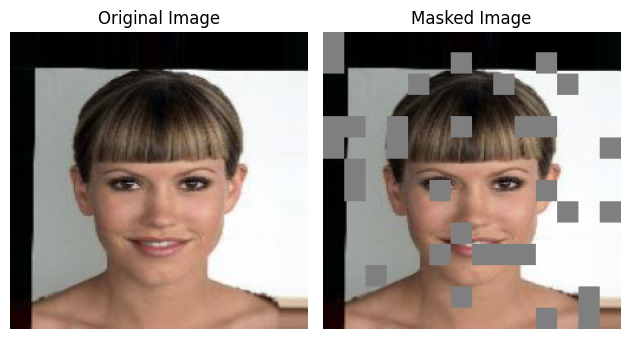

In [9]:
def unnormalize_and_convert(image):
    image = image.permute(1, 2, 0).cpu().detach().numpy()  
    image = (image * 0.5) + 0.5  
    image = np.clip(image, 0, 1)  
    return image

original_image, masked_image, mask = train_dataset[random.randint(0,2000)]  

plt.figure()

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(unnormalize_and_convert(original_image))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Masked Image")
plt.imshow(unnormalize_and_convert(masked_image))
plt.axis('off')

plt.tight_layout()
plt.show()

GAN Definition
-----------------------

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator: CNN-based U-Net
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1),  # Input: RGB + mask
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),  # Output in [-1, 1]
        )

    def forward(self, masked_image, mask):
        batch_size, _, height, width = masked_image.shape

        # Calculate patch size from mask shape
        patch_size = height // int(mask.shape[1] ** 0.5)  # Assuming square grid of patches
        num_patches_h = height // patch_size
        num_patches_w = width // patch_size

        # Reshape and expand mask to match image dimensions
        mask = mask.view(batch_size, num_patches_h, num_patches_w)
        mask = mask.repeat_interleave(patch_size, dim=1).repeat_interleave(patch_size, dim=2)
        mask = mask.unsqueeze(1).float()  # Add channel dimension

        # Concatenate masked_image and mask along the channel dimension
        x = torch.cat([masked_image, mask], dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Discriminator: CNN-based PatchGAN
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
        )

    def forward(self, image):
        return self.model(image).view(-1)

Plot Sample Image
--------


In [26]:
def plot_sample_image(original_image, masked_image, inpainted_image, expanded_mask, save_path=None, image_name=None):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(unnormalize_and_convert(original_image))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(unnormalize_and_convert(masked_image))
    ax[1].set_title("Masked Image")
    ax[1].axis('off')

    inpainted_image = inpainted_image * expanded_mask + masked_image
    ax[2].imshow(unnormalize_and_convert(inpainted_image))
    ax[2].set_title("Inpainted Image")
    ax[2].axis('off')
    
    plt.tight_layout()

    if save_path and image_name is not None:
        os.makedirs(save_path, exist_ok=True)  # Ensure directory exists
        file_path = os.path.join(save_path, image_name)
        plt.savefig(file_path)
        print(f"Saved: {file_path}")
    plt.show()

Performance Metrics
--------------------

In [12]:
def psnr(output, target, mask):
    """Compute PSNR (Peak Signal-to-Noise Ratio)"""
    output = output * mask
    target = target * mask
    mse = torch.mean((output - target) ** 2, dim=(1, 2, 3))
    mse = torch.where(mse == 0, torch.tensor(1e-10).to(mse.device), mse)
    psnr_value = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr_value.mean().item()

def pixel_accuracy(output, target, mask):
    output = output * mask
    target = target * mask
    correct = (torch.abs(output - target) < 1).float()
    denominator = mask.sum(dim=(1, 2, 3))
    denominator = torch.where(denominator == 0, torch.tensor(1.0).to(denominator.device), denominator)
    acc_per_image = correct.sum(dim=(1, 2, 3)) / denominator
    return acc_per_image.mean().item()

Loss Functions
-----------------------------

In [13]:
# Loss Functions
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True):
        super(GANLoss, self).__init__()
        self.criterion = nn.MSELoss() if use_lsgan else nn.BCEWithLogitsLoss()

    def forward(self, prediction, target_is_real):
        target = torch.ones_like(prediction) if target_is_real else torch.zeros_like(prediction)
        return self.criterion(prediction, target)

# Loss Functions
class LightweightPerceptualLoss(nn.Module):
    def __init__(self):
        super(LightweightPerceptualLoss, self).__init__()
        vgg = vgg11(pretrained=True).features[:8]
        self.feature_extractor = nn.Sequential(*list(vgg))
        for param in self.feature_extractor.parameters():
            param.requires_grad = False 

    def forward(self, output, target):
        output_features = self.feature_extractor(output)
        target_features = self.feature_extractor(target)
        loss = F.mse_loss(output_features, target_features)  # MSE between feature maps
        return loss

class CombinedLoss(nn.Module):
    def __init__(self, perceptual_weight=0.3, ssim_weight=0.7):
        super(CombinedLoss, self).__init__()
        self.perceptual_loss = LightweightPerceptualLoss()
        self.ssim_loss = SSIM(data_range=1, size_average=True, channel=3)
        self.perceptual_weight = perceptual_weight
        self.ssim_weight = ssim_weight

    def forward(self, output, target, expanded_mask):
        masked_output = output * expanded_mask
        masked_target = target * expanded_mask

        ssim_loss = 1 - self.ssim_loss(masked_output, masked_target)
        perceptual_loss = self.perceptual_loss(output, target)
        total_loss = self.ssim_weight * ssim_loss + self.perceptual_weight * perceptual_loss
        return total_loss

Train Model
-----------------------------

In [21]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
lr = 2e-4
beta1 = 0.5
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss functions
gan_loss = GANLoss().to(device)
combined_loss = CombinedLoss().to(device)

# Save Checkpoint
def save_checkpoint(epoch, generator, discriminator, g_optimizer, d_optimizer, best_valid_loss, path="checkpoint.pth"):
    checkpoint = {
        "epoch": epoch,
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "g_optimizer_state_dict": g_optimizer.state_dict(),
        "d_optimizer_state_dict": d_optimizer.state_dict(),
        "best_valid_loss": best_valid_loss,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved: {path}")
    
def train_model(generator, discriminator, g_optimizer, d_optimizer, start_epoch, best_valid_loss, train_loader, valid_loader, num_epochs=1, device="cuda"):
    patience = 3
    patience_counter = 0

    generator.to(device)
    discriminator.to(device)
    combined_loss = CombinedLoss().to(device)
    gan_loss = GANLoss().to(device)

    log_file = "training_metrics.csv"
    
    # Initialize CSV logging
    with open(log_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Validation Loss", "Train PSNR", "Validation PSNR", "Train Accuracy", "Validation Accuracy"])

    for epoch in range(start_epoch, start_epoch + num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_psnr = 0.0
        val_psnr = 0.0
        train_accuracy = 0.0
        val_accuracy = 0.0

        # Training Loop
        generator.train()
        discriminator.train()
        for images, masked_images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}, Train"):
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

            # Reshape mask to match the patch grid and expand to full image size
            batch_size, _, height, width = images.shape
            patch_size = height // int(masks.shape[1] ** 0.5)  # Assuming square patch grid
            mask_reshaped = masks.view(batch_size, int(height / patch_size), int(width / patch_size))  # Patch grid shape
            expanded_mask = mask_reshaped.repeat_interleave(patch_size, dim=1).repeat_interleave(patch_size, dim=2).unsqueeze(1).float()

            # Discriminator Training
            discriminator.zero_grad()
            real_output = discriminator(images)
            fake_images = generator(masked_images, masks).detach()
            fake_output = discriminator(fake_images)

            d_real_loss = gan_loss(real_output, True)
            d_fake_loss = gan_loss(fake_output, False)
            d_loss = (d_real_loss + d_fake_loss) * 0.5
            d_loss.backward()
            d_optimizer.step()

            # Generator Training
            generator.zero_grad()
            fake_images = generator(masked_images, masks)
            fake_output = discriminator(fake_images)

            g_gan_loss = gan_loss(fake_output, True)
            g_combined_loss = combined_loss(fake_images, images, expanded_mask)
            g_loss = g_gan_loss + g_combined_loss
            g_loss.backward()
            g_optimizer.step()

            # Metrics
            train_loss += g_loss.item()
            train_psnr += psnr(fake_images, images, expanded_mask)
            train_accuracy += pixel_accuracy(fake_images, images, expanded_mask)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_psnr = train_psnr / len(train_loader)
        avg_train_accuracy = train_accuracy / len(train_loader)

        # Validation Loop
        generator.eval()
        discriminator.eval()
        with torch.no_grad():
            for images, masked_images, masks in tqdm(valid_loader, desc=f"Epoch {epoch + 1}, Validation"):
                images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

                # Reshape mask to match the patch grid and expand to full image size
                batch_size, _, height, width = images.shape
                patch_size = height // int(masks.shape[1] ** 0.5)  # Assuming square patch grid
                mask_reshaped = masks.view(batch_size, int(height / patch_size), int(width / patch_size))  # Patch grid shape
                expanded_mask = mask_reshaped.repeat_interleave(patch_size, dim=1).repeat_interleave(patch_size, dim=2).unsqueeze(1).float()

                fake_images = generator(masked_images, masks)
                fake_output = discriminator(fake_images)

                g_gan_loss = gan_loss(fake_output, True)
                g_combined_loss = combined_loss(fake_images, images, expanded_mask)
                g_loss = g_gan_loss + g_combined_loss

                val_loss += g_loss.item()
                val_psnr += psnr(fake_images, images, expanded_mask)
                val_accuracy += pixel_accuracy(fake_images, images, expanded_mask)

        avg_val_loss = val_loss / len(valid_loader)
        avg_val_psnr = val_psnr / len(valid_loader)
        avg_val_accuracy = val_accuracy / len(valid_loader)

        print(f"Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Train PSNR: {avg_train_psnr:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation PSNR: {avg_val_psnr:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

        # Save Best Model
        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            patience_counter = 0
            save_checkpoint(epoch + 1, generator, discriminator, g_optimizer, d_optimizer, best_valid_loss, path="best_model.pth")
        else:
            patience_counter += 1
            if patience_counter > patience:
                print("Early stopping")
                break

        # Append metrics to CSV
        with open(log_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                epoch + 1,
                avg_train_loss,
                avg_val_loss,
                avg_train_psnr,
                avg_val_psnr,
                avg_train_accuracy,
                avg_val_accuracy
            ])
            
# Start training

# Initialize Generator and Discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Scaler (if using mixed precision training)
scaler = torch.cuda.amp.GradScaler()

# Dataloaders (Assume train_loader and valid_loader are already defined)
# train_loader: DataLoader for training data
# valid_loader: DataLoader for validation data

# Training
start_epoch = 0
best_valid_loss = float('inf')
num_epochs = 10

train_model(
    generator=generator,
    discriminator=discriminator,
    g_optimizer=g_optimizer,
    d_optimizer=d_optimizer,
    start_epoch=start_epoch,
    best_valid_loss=best_valid_loss,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=num_epochs,
    device=device
)

Epoch 1, Validation: 100%|██████████| 830/830 [06:34<00:00,  2.10it/s]


Epoch 1: Train Loss: 0.7342, Train PSNR: 19.8446, Train Accuracy: 15.2710
Validation Loss: 0.8893, Validation PSNR: 20.4002, Validation Accuracy: 15.3104
Checkpoint saved: best_model.pth


Epoch 2, Validation: 100%|██████████| 830/830 [06:34<00:00,  2.11it/s]


Epoch 2: Train Loss: 1.1894, Train PSNR: 18.7765, Train Accuracy: 15.2743
Validation Loss: 1.2025, Validation PSNR: 18.4767, Validation Accuracy: 15.2819


Epoch 3, Train:  47%|████▋     | 3136/6639 [34:16<38:16,  1.53it/s]  


KeyboardInterrupt: 

Load Best Transformer
-----------------------------

In [22]:
# Load the Best Model
checkpoint = torch.load("best_model.pth", map_location=device)

# Initialize Generator and Discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Load Generator and Discriminator States
generator.load_state_dict(checkpoint["generator_state_dict"])
discriminator.load_state_dict(checkpoint["discriminator_state_dict"])

# Optionally Load Optimizers if Resuming Training
g_optimizer.load_state_dict(checkpoint["g_optimizer_state_dict"])
d_optimizer.load_state_dict(checkpoint["d_optimizer_state_dict"])

# Load the Best Validation Loss and Start Epoch
best_valid_loss = checkpoint["best_valid_loss"]
start_epoch = checkpoint["epoch"]

print(f"Best model loaded from epoch {start_epoch} with validation loss {best_valid_loss:.4f}")

Best model loaded from epoch 1 with validation loss 0.8893


Evaluate
-----------------------------

Evaluating:   7%|▋         | 58/830 [00:12<02:44,  4.70it/s]

Saved: Evaluation_Samples\Sample_58.png


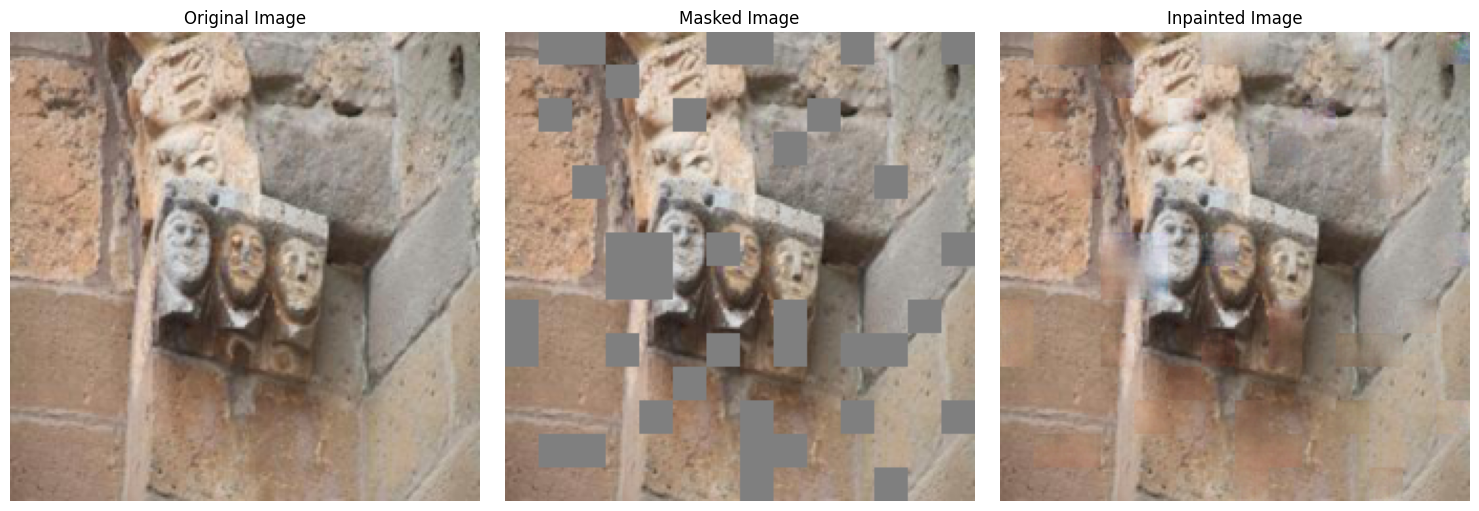

Evaluating:  24%|██▎       | 197/830 [00:41<02:09,  4.90it/s]

Saved: Evaluation_Samples\Sample_197.png


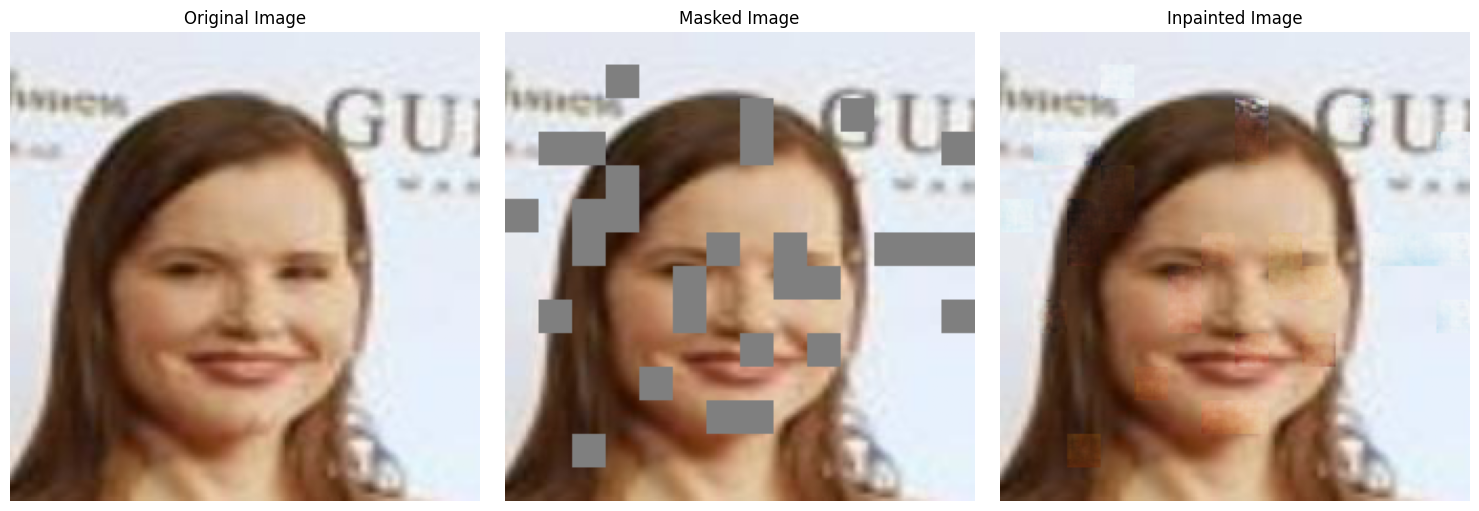

Evaluating:  43%|████▎     | 361/830 [01:15<01:39,  4.72it/s]

Saved: Evaluation_Samples\Sample_361.png


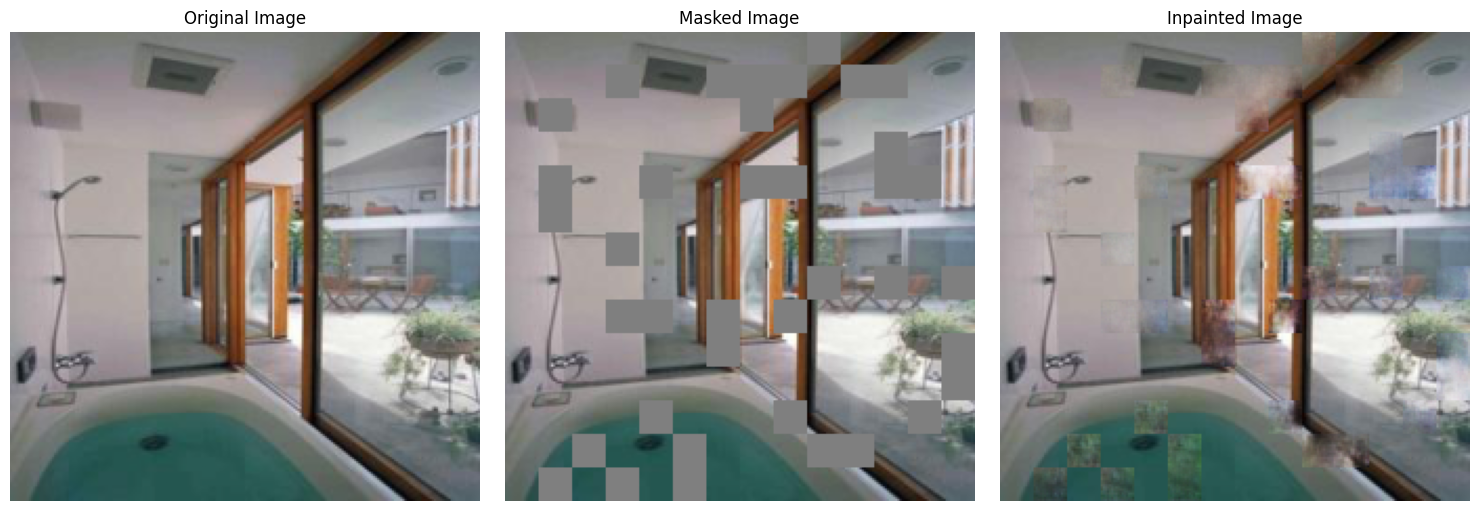

Evaluating:  66%|██████▋   | 551/830 [01:57<01:00,  4.61it/s]

Saved: Evaluation_Samples\Sample_551.png


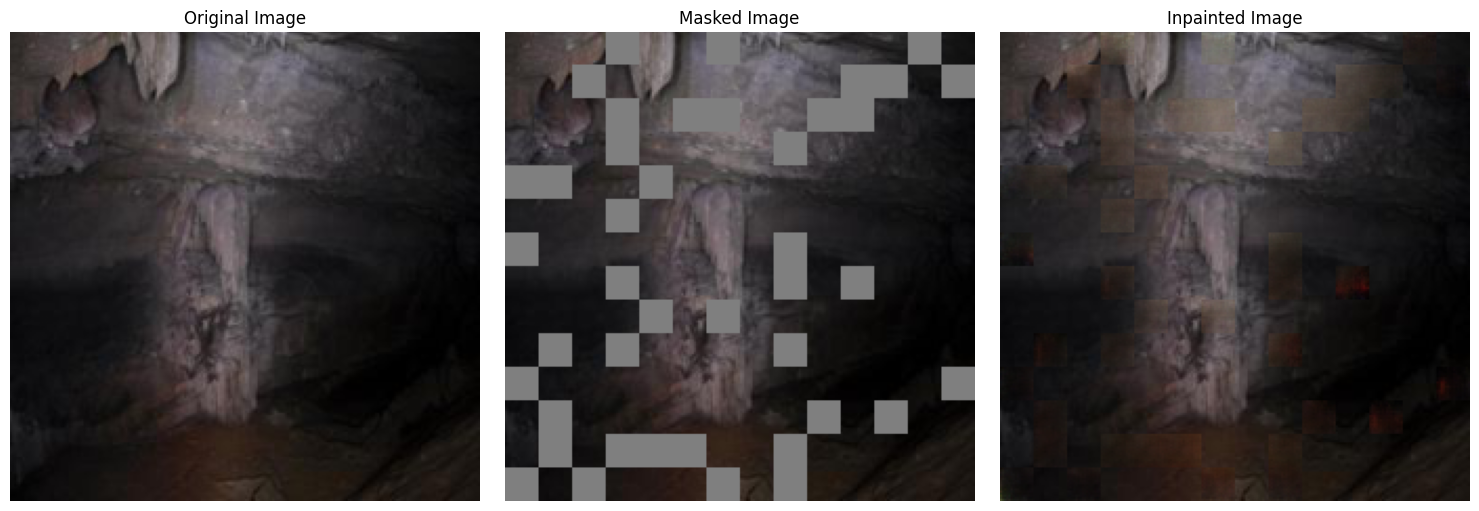

Evaluating:  80%|███████▉  | 661/830 [02:20<00:34,  4.86it/s]

Saved: Evaluation_Samples\Sample_661.png


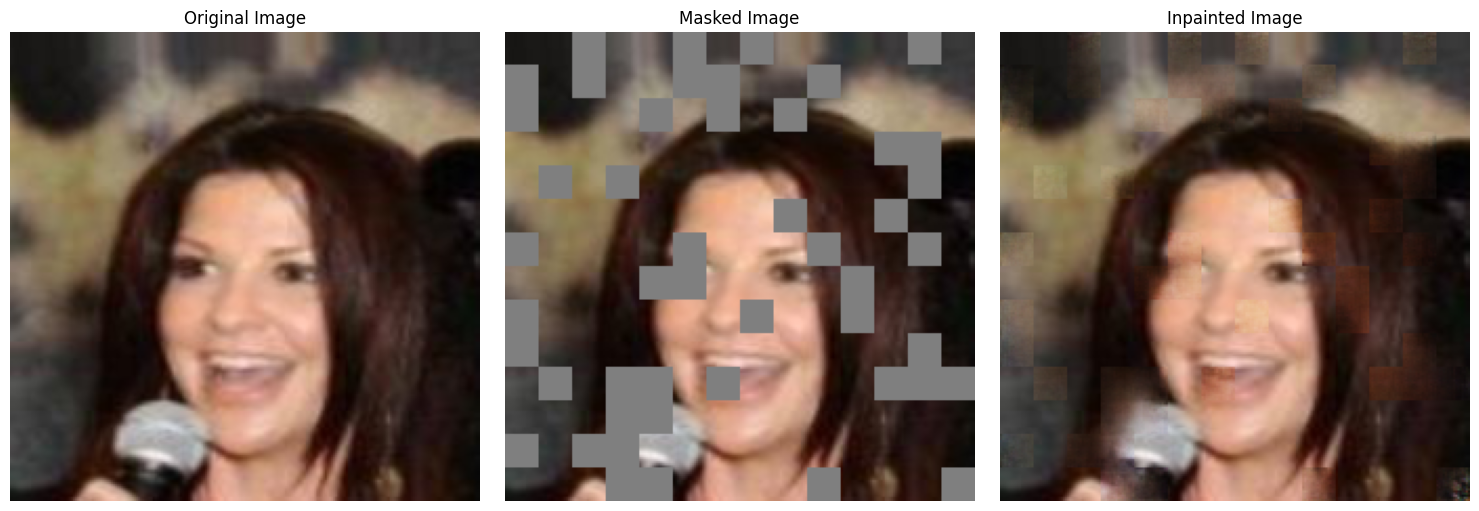

Evaluating: 100%|██████████| 830/830 [02:56<00:00,  4.70it/s]

Test Loss: 0.8887, PSNR: 20.4060, Accuracy: 15.3039
(0.8887001533106149, 20.40596946808229, 15.303855802926673)


In [33]:
# Evaluation Function
def evaluate_model(generator, discriminator, dataloader, gan_loss, combined_loss, device="cuda", sample_size=5):
    generator.eval()
    discriminator.eval()
    test_loss = 0.0
    test_psnr = 0.0
    test_accuracy = 0.0

    sample_size = min(sample_size, len(dataloader))

    random_indices = random.sample(range(len(dataloader)), sample_size)
    
    with torch.no_grad():
        for idx, (images, masked_images, masks) in enumerate(tqdm(dataloader, desc="Evaluating")):
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

            # Reshape mask to match the patch grid and expand to full image size
            batch_size, _, height, width = images.shape
            patch_size = height // int(masks.shape[1] ** 0.5)  # Assuming square patch grid
            mask_reshaped = masks.view(batch_size, int(height / patch_size), int(width / patch_size))  # Patch grid shape
            expanded_mask = mask_reshaped.repeat_interleave(patch_size, dim=1).repeat_interleave(patch_size, dim=2).unsqueeze(1).float()

            # Generator outputs
            fake_images = generator(masked_images, masks)

            # Discriminator outputs
            fake_output = discriminator(fake_images)

            # Loss calculations
            g_gan_loss = gan_loss(fake_output, True)
            g_combined_loss = combined_loss(fake_images, images, expanded_mask)
            total_loss = g_gan_loss + g_combined_loss

            # Metrics calculations
            test_loss += total_loss.item()
            test_psnr += psnr(fake_images, images, expanded_mask)
            test_accuracy += pixel_accuracy(fake_images, images, expanded_mask)

            # Save random sample outputs
            if idx in random_indices:
                plot_sample_image(
                    original_image=images[0],
                    masked_image=masked_images[0],
                    inpainted_image=fake_images[0],
                    expanded_mask=expanded_mask[0],
                    save_path="Evaluation_Samples",
                    image_name=f"Sample_{idx}.png",
                )

    avg_test_loss = test_loss / len(dataloader)
    avg_test_psnr = test_psnr / len(dataloader)
    avg_test_accuracy = test_accuracy / len(dataloader)

    print(f"Test Loss: {avg_test_loss:.4f}, PSNR: {avg_test_psnr:.4f}, Accuracy: {avg_test_accuracy:.4f}")
    return avg_test_loss, avg_test_psnr, avg_test_accuracy


# Evaluation

gan_loss = GANLoss().to(device)
combined_loss = CombinedLoss().to(device)

# Evaluate the model
test_results = evaluate_model(
    generator=generator,
    discriminator=discriminator,
    dataloader=test_loader,  # Assuming test_loader is defined
    gan_loss=gan_loss,
    combined_loss=combined_loss,
    device=device
)

print(test_results)

Collected Dataset
-----------------------------

64


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Saved: Evaluation_Samples\Sample_0.png


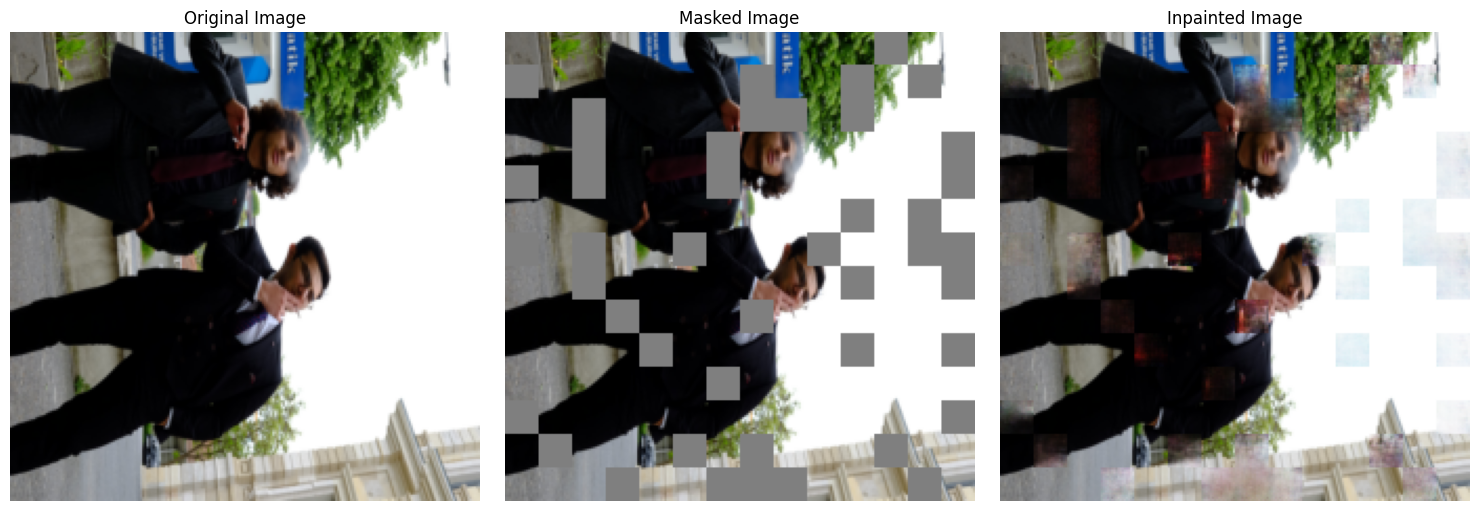

Evaluating:  25%|██▌       | 1/4 [00:02<00:06,  2.05s/it]

Saved: Evaluation_Samples\Sample_1.png


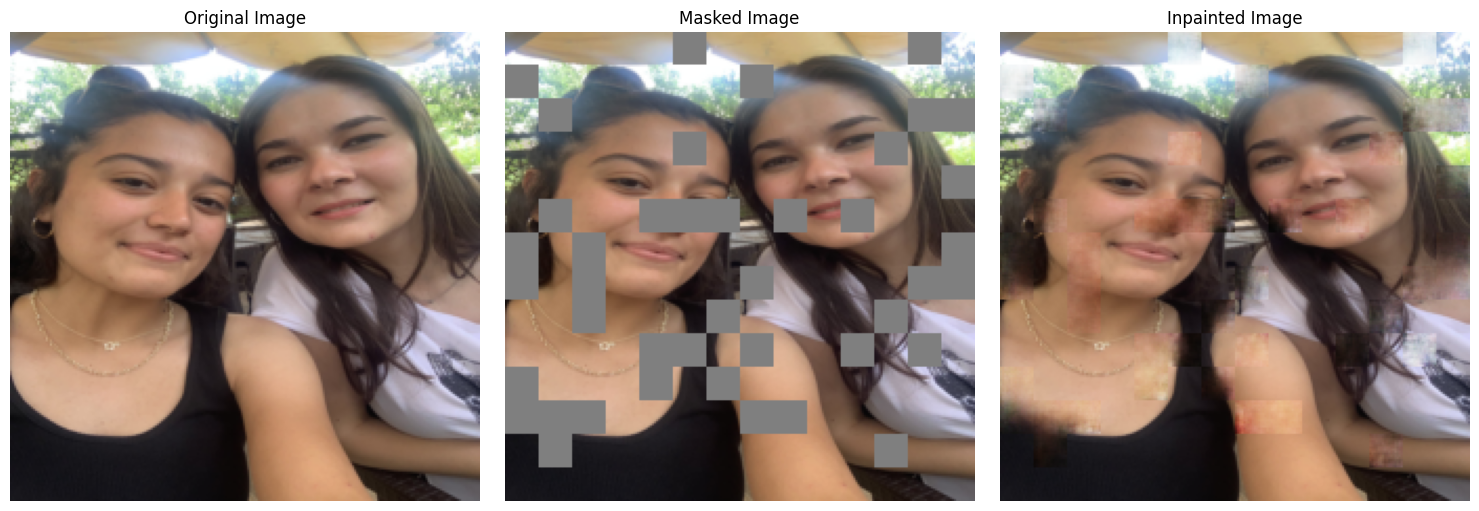

Evaluating:  50%|█████     | 2/4 [00:04<00:04,  2.04s/it]

Saved: Evaluation_Samples\Sample_2.png


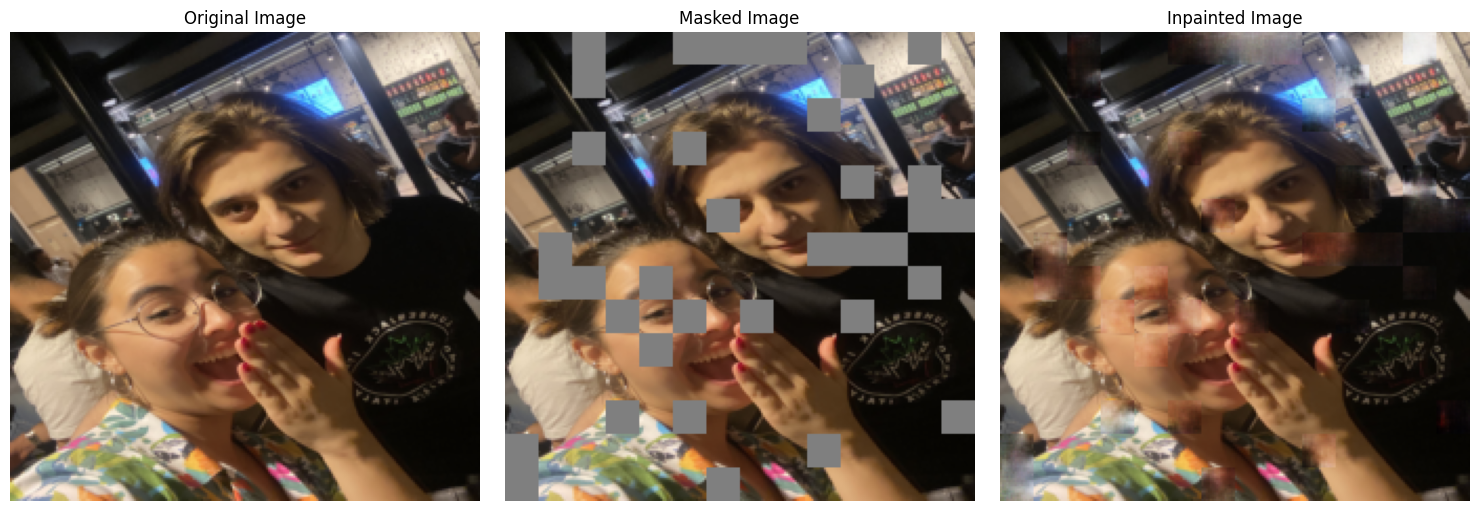

Evaluating:  75%|███████▌  | 3/4 [00:05<00:01,  1.92s/it]

Saved: Evaluation_Samples\Sample_3.png


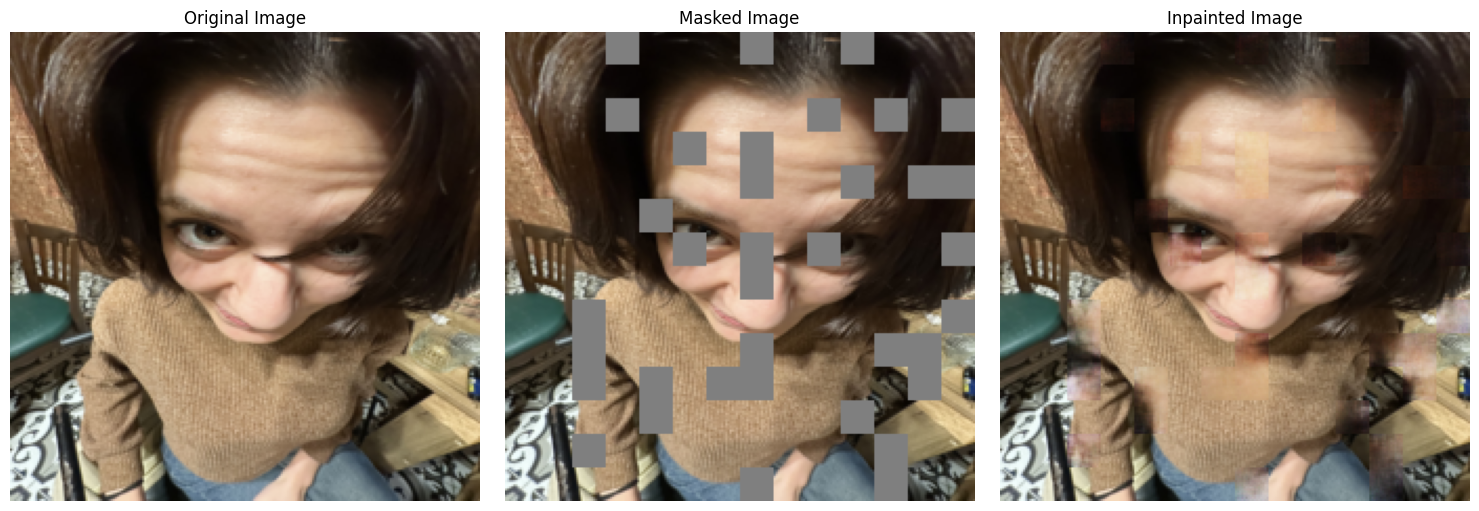

Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]

Test Loss: 0.9258, PSNR: 20.1395, Accuracy: 15.4235
(0.9258107095956802, 20.139469623565674, 15.423479080200195)


In [34]:
dataset_collected = datasets.ImageFolder(root="./Collected_Photo")
custom_data_collected = Custom_Dataset(dataset_collected, transform=transform_image)


batch_size = 16
collected_loader = DataLoader(custom_data_collected, batch_size=batch_size, shuffle=False)  

print(len(collected_loader)*16)

# Evaluate the model
test_results = evaluate_model(
    generator=generator,
    discriminator=discriminator,
    dataloader=collected_loader,  # Assuming test_loader is defined
    gan_loss=gan_loss,
    combined_loss=combined_loss,
    device=device
)

print(test_results)

Curves
-----------------------------

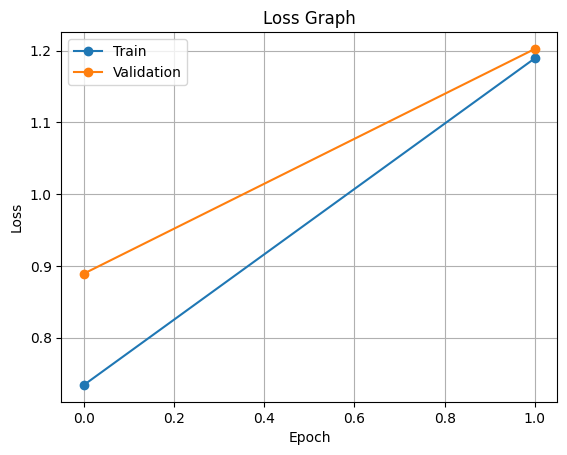

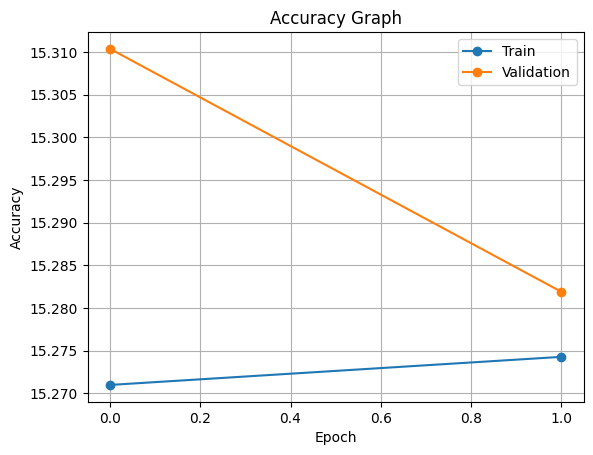

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the metrics file
df = pd.read_csv("training_metrics.csv")

# Separate different metrics
df_loss = df[["Train Loss", "Validation Loss"]]
df_psnr = df[["Train PSNR", "Validation PSNR"]]
df_accuracy = df[["Train Accuracy", "Validation Accuracy"]]

# Define a function to plot metrics
def plot_graph(df, name):
    plt.figure()
    plt.plot(df, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel(name)
    plt.legend(["Train", "Validation"])
    plt.title(f"{name} Graph")
    plt.grid()
    plt.show()

# Plot the metrics
plot_graph(df_loss, "Loss")
plot_graph(df_psnr, "PSNR")
plot_graph(df_accuracy, "Accuracy")